# Todo
Basic Stats
* alle Dialogdaten und alle Skripte in jeweils eine Datei

auf Basis der Dialogdaten:
* ~~Sprecheranteile der Personen: mit groupby nach Personen -> Wörter zählen (zwischen Leerzeilen) -> Maxi~~
* Häufigkeitstabellen pro Person (Liste der x häufigsten Wörter), als Kontrolle für die Wortwolke
* ~~Dialoge aller Personen extrahieren (Frodo, Sam, Merry, Pippin, Gandalf, Aragorn, Legolas, Gimli, Gollum, Smeagol, Saruman, Sauron) -> Marina, aus Neugier ergänzt (aber nicht für Analyse zur Hauptperson relevant: Arwen, Eowyn, Theoden)~~
* ~~Wordclouds für Personen erstellen -> Marina~~
* Wodurch entsteht das mysteriöse "s" in den Wordclouds? -> Bei Datenbereinigung ansetzen
* Interpretation der Wortwolken -> In "Ergebnisse.md" sammeln

auf Basis der Regieanweisungen und Dialogdaten
* zählen wie häufig die einzelnen Personen erwähnt werden -> Maxi

Einarbeitung in Sentiment Analysis

# NLP

In [1]:
from bs4 import BeautifulSoup
import requests
import os
import re
import pandas as pd
import numpy as np
from textblob import TextBlob
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

## Helper functions

### Get complete dialog data of a single film

In [2]:
def getDialogOfFilm(dfFilm):
    film = dfFilm["SUBTITLE TEXT"]
    film_text = ""
    for text in film:
        if (not pd.isna(text)):
            film_text = f'{film_text} {text}'
            # replaces "... ..." or "..." (and variations with whitespace) with one single space character
            film_text = re.sub(r'\s?\.\.\.\s?\.?\.?\.?\s?', " ", film_text)
    return film_text

### Get dialog data of specific character

In [3]:
# takes the name of a character (exactly as spelled in the data frame) and returns all dialog of this character
def getTextOfCharacter(dfFilm, character):
    character = dfFilm[dfFilm["SPEAKER"] == character]
    character_text = ""
    for text in character["SUBTITLE TEXT"]:
        if (not pd.isna(text)):
            character_text = f'{character_text} {text}'
            # replaces "... ..." with space character
            character_text = re.sub(r'\s?\.\.\.\s?\.?\.?\.?\s?', " ", character_text)
    return character_text

### Count words

In [4]:
def word_count(string):
    return(len(string.strip().split(" ")))

### Count frequency of single word

In [5]:
def word_freq(string,word):
    string=string.lower() 
    return string.count(word)

### Count all words frequency

In [6]:
# gets frequency of the n most used words
def get_word_frequency(text, word_number):
    # remove punctiation to standardize words (Sam?, Sam., Sam! --> Sam)
    text = re.sub(r"\.", "", text)
    text = re.sub(r"\!", "", text)
    text = re.sub(r"\?", "", text)
    text = re.sub(r"\,", "", text)
    #count frequency
    frequency = dict(Counter(text.split()))
    # filter frequency list by using stopwords list from wordcloud module
    stopwords = list(STOPWORDS)
    frequency_cleaned = {k: v for k, v in frequency.items() if (k not in stopwords and k.lower() not in stopwords)}
    frequency_sorted = sorted(frequency_cleaned.items(), key=lambda x: x[1], reverse=True)
    return frequency_sorted[:word_number]

### Generate wordclouds

Wordcloud settings:

1.) built-in stopwords list is used by default

2.) max. number of words is 200

3.) no collocations

Every time the cell is run, the color and positoning of the words will be slightly different.

In [7]:
# function to generate wordcloud
def make_wordcloud(data):
    wordcloud = WordCloud(background_color = 'white', collocations=False, width=1920, height=1080).generate(data)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return wordcloud

## Komplette Dialogdaten der drei Filme

In [8]:
# load reduced csv dialog data of script 1
df_dialog_film_1 = pd.read_csv("C:/Users/maxim/Desktop/Uni/MASTER Digitale Methodik/3. Wintersemester/Natural Language Processing/data/LOTR Subtitles reduced film 1.csv", sep=";")
df_dialog_film_1

,ORIG ID,SPEAKER,SUBTITLE TEXT,SCENE,ITUNES CHAPTER
0,NaN,NaN,NaN,NaN,1.0
1,2,Galadriel,The world is changed.,NaN,NaN
2,4,Galadriel,I feel it in the water.,NaN,NaN
3,6,Galadriel,I feel it in the earth.,NaN,NaN
4,8,Galadriel,I smell it in the air.,NaN,NaN
...,...,...,...,...,...
1968,1779,Frodo,I don't suppose we'll ever see them again.,NaN,NaN
1969,1780,Sam,"We may yet, Mr. Frodo.",NaN,NaN
1970,1781,Sam,We may.,NaN,NaN
1971,1782,Frodo,Sam...,NaN,NaN


In [9]:
# get dialog text of film 1
film_1_text = getDialogOfFilm(df_dialog_film_1)
film_1_text

" The world is changed. I feel it in the water. I feel it in the earth. I smell it in the air. Much that once was  is lost. For none now live who remember it. It began with the forging of the Great Rings. Three were given to the Elves: Immortal, wisest and fairest of all beings. Seven to the Dwarf-lords: Great miners and craftsmen of the mountain halls. And nine  nine rings were gifted to the race of Men  who, above all else, desire power. For within these rings was bound the strength and will to govern each race. But they were all of them deceived. For another ring was made. In the land of Mordor, in the fires of Mount Doom  the Dark Lord Sauron forged in secret a Master Ring  to control all others. And into this Ring he poured his cruelty, his malice  and his will to dominate all life. One Ring to rule them all. One by one  the Free Lands of Middle-earth fell to the power of the ring. But there were some who resisted. A Last Alliance of Men and Elves marched against the armies of Mor

In [10]:
# load reduced csv dialog data of script 2
df_dialog_film_2 = pd.read_csv("C:/Users/maxim/Desktop/Uni/MASTER Digitale Methodik/3. Wintersemester/Natural Language Processing/data/LOTR Subtitles reduced film 2.csv", sep=";")
df_dialog_film_2

,ORG ID,SPEAKER,SUBTITLE TEXT,SCENE,ITUNES CHAPTER
0,NaN,NaN,NaN,NaN,1.0
1,1.0,Gandalf,You cannot pass!,NaN,NaN
2,1.0,Frodo,Gandalf!,NaN,NaN
3,2.0,Gandalf,"I am a servant of the Secret Fire, wielder of ...",NaN,NaN
4,3.0,Gandalf,Go back to the Shadow.,NaN,NaN
...,...,...,...,...,...
2191,2064.0,Gollum,And then we takes it once they're dead.,NaN,NaN
2192,2065.0,Smeagol,Once they're dead.,NaN,NaN
2193,2066.0,Smeagol,"Come on, Hobbits. Long ways to go yet.",NaN,NaN
2194,2067.0,Smeagol,Smeagol will show you the way.,NaN,NaN


In [11]:
# get dialog text of script 2
film_2_text = getDialogOfFilm(df_dialog_film_2)
film_2_text

' You cannot pass! Gandalf! I am a servant of the Secret Fire, wielder of the flame of Anor. Go back to the Shadow. The dark fire will not avail you, flame of Udun! You shall not pass! No! No! Gandalf! Fly, you fools. No! Gandalf! Gandalf! What is it, Mr. Frodo? Nothing. Just a dream. Can you see the bottom? No! Don\'t look down, Sam! Just keep going! Catch it! Grab it, Mr. Frodo! Mr. Frodo! I think I\'ve found the bottom. Bogs and rope, and goodness knows what. It\'s not natural. None of it. What\'s in this? Nothing. Just a bit of seasoning. I thought maybe if we was having a roast chicken one night or something. Roast chicken?! You never know. Sam. My dear Sam. It\'s very special, that. It\'s the best salt in all the Shire. It is special. It\'s a little bit of home. We can\'t leave this here for someone to follow us down. Who\'s gonna follow us down here, Mr. Frodo? It\'s a shame, really. Lady Galadriel gave me that. Real Elvish rope. Well, there\'s nothing for it. It\'s one of my kn

In [12]:
# load reduced csv dialog data of script 3
df_dialog_film_3 = pd.read_csv("C:/Users/maxim/Desktop/Uni/MASTER Digitale Methodik/3. Wintersemester/Natural Language Processing/data/LOTR Subtitles reduced film 3.csv", sep=";")
df_dialog_film_3

,ORG ID,SPEAKER,SUBTITLE TEXT,SCENE,ITUNES CHAPTER
0,NaN,NaN,NaN,NaN,1.0
1,1.0,Deagol,Sméagol!,NaN,NaN
2,2.0,Deagol,I've got one!,NaN,NaN
3,3.0,Deagol,"I've got a fish, Smeag. Smeagol!",NaN,NaN
4,4.0,Smeagol,Pull it in. Go on. Go on. Go on. Pull it in.,NaN,NaN
...,...,...,...,...,...
1871,1811.0,Frodo,You will have to be one and whole for many years.,NaN,NaN
1872,1812.0,Frodo,You have so much to enjoy and to be and to do.,NaN,NaN
1873,1813.0,Frodo,Your part in the story will go on.,NaN,NaN
1874,1814.0,Sam,Well...,NaN,NaN


In [13]:
# get dialog text of script 3
film_3_text = getDialogOfFilm(df_dialog_film_3)
film_3_text

' Sméagol! I\'ve got one! I\'ve got a fish, Smeag. Smeagol! Pull it in. Go on. Go on. Go on. Pull it in. Deagol! Deagol? Deagol. Give us that, Deagol, my love. Why? Because  it\'s my birthday and I wants it. My precious. They cursed us. Murderer. “Murderer” they called us. They cursed us and drove us away. Gollum. Gollum. Gollum. And we wept, precious. We wept to be so alone. and cool So nice for feet And we only wish To catch a fish So juicy sweet And we forgot the taste of bread  the sound of trees  the softness of the wind. We even forgot our own name. My precious. Wake up! Wake up! Wake up, sleepies. We must go, yes. We must go at once. Haven\'t you had any sleep, Mr. Frodo? I\'ve gone and had too much. Must be getting late. No. It isn\'t. It isn\'t midday yet. The days are growing darker. Come on! Must go! No time! Not before Mr. Frodo\'s had something to eat. No time to lose, silly. Here. What about you? Oh, no, I\'m not hungry. Leastways, not for lembas bread. Sam. All right. We

In [14]:
# concat dialog text from all three movies
dialog_text_all_films = f'{film_1_text} {film_2_text} {film_3_text}'
dialog_text_all_films

' The world is changed. I feel it in the water. I feel it in the earth. I smell it in the air. Much that once was  is lost. For none now live who remember it. It began with the forging of the Great Rings. Three were given to the Elves: Immortal, wisest and fairest of all beings. Seven to the Dwarf-lords: Great miners and craftsmen of the mountain halls. And nine  nine rings were gifted to the race of Men  who, above all else, desire power. For within these rings was bound the strength and will to govern each race. But they were all of them deceived. For another ring was made. In the land of Mordor, in the fires of Mount Doom  the Dark Lord Sauron forged in secret a Master Ring  to control all others. And into this Ring he poured his cruelty, his malice  and his will to dominate all life. One Ring to rule them all. One by one  the Free Lands of Middle-earth fell to the power of the ring. But there were some who resisted. A Last Alliance of Men and Elves marched against the armies of Mor

## Dialogdaten der einzelnen Figuren

### Dialogdaten - Frodo

In [15]:
# Frodo's dialog text - Film 1
frodo_1 = getTextOfCharacter(df_dialog_film_1, "Frodo")
#frodo_1

In [16]:
# Frodo's dialog text - Film 2
frodo_2 = getTextOfCharacter(df_dialog_film_2, "Frodo")
#frodo_2

In [17]:
# Frodo's dialog text - Film 3
frodo_3 = getTextOfCharacter(df_dialog_film_3, "Frodo")
#frodo_3

In [18]:
# Frodo's dialog text - all films
frodo_all = f'{frodo_1} {frodo_2} {frodo_3}'
frodo_all

" You're late. It's wonderful to see you, Gandalf! You know Bilbo. He's got the whole piece in an uproar. Half the Shire's been invited. And the rest of them are turning up anyway. To tell you the truth, Bilbo's been a bit odd lateIy. I mean, more than usual. He's taken to locking himself in his study. He spends hours and hours poring over old maps when he thinks I'm not looking. He's up to something. All right, then. Keep your secrets. But I know you have something to do with it. Before you came along, we Bagginses were very well thought of. Never had any adventures or did anything unexpected. Whatever you did, you've been officially labeled a disturber of the peace. Gandalf? I'm glad you're back. Go on, Sam. Ask Rosie for a dance. Oh, no, you don't. Go on! Bilbo? Bilbo, have you been at the Gaffer's home brew? Bilbo. Bilbo, watch out for the dragon! Speech! Bilbo! Bilbo! He's gone, hasn't he? He talked for so long about leaving  I didn't think he'd really do it. Gandalf? Where are yo

## Dialogdaten - Gandalf

In [19]:
# Gandalf's dialog text - film 1
gandalf_1 = getTextOfCharacter(df_dialog_film_1, "Gandalf")
#gandalf_1

In [20]:
# Gandalf's dialog text - film 2
gandalf_2 = getTextOfCharacter(df_dialog_film_2, "Gandalf")
#gandalf_2

In [21]:
# Gandalf's dialog text - film 3
gandalf_3 = getTextOfCharacter(df_dialog_film_3, "Gandalf")
#gandalf_3

In [22]:
# Gandalfs's dialog text - all films
gandalf_all = f'{gandalf_1} {gandalf_2} {gandalf_3}'
gandalf_all

" Down from the door where it began And I must follow if I can The road goes ever on and on Down from the door where it began Now far ahead the road has gone And I must follow if I can A wizard is never late, Frodo Baggins. Nor is he early. He arrives precisely when he means to. You didn't think I'd miss your Uncle Bilbo's birthday? So how is the old rascal? I hear it's going to be a party of special magnificence. Well, that should please him. What? Good gracious me. Indeed. If you're referring to the incident with the dragon. I was barely involved. All I did was give your uncle a little nudge out of the door. Oh, really? So am I, dear boy. So am I. Whoa, whoa. And what about very old friends? Bilbo Baggins. Good to see you. 111 years old! Who would believe it? You haven't aged a day. Just tea, thank you. Just tea, thank you. No, not at all. So you mean to go through with your plan? Frodo suspects something. You will tell him, won't you? He's very fond of you. Whoa Up they go! Meriadoc

## Dialogdaten - Sam

In [23]:
# Sams's dialog text - film 1
sam_1 = getTextOfCharacter(df_dialog_film_1, "Sam")
#sam_1

In [24]:
# Sams's dialog text - film 2
sam_2 = getTextOfCharacter(df_dialog_film_2, "Sam")
#sam_2

In [25]:
# Sams's dialog text - film 3
sam_3 = getTextOfCharacter(df_dialog_film_3, "Sam")
#sam_3

In [26]:
# Sams's dialog text - all films
sam_all = f'{sam_1} {sam_2} {sam_3}'
sam_all

' I think I\'ll just have another ale. Good night. Mind who you\'re sweet-taking. Does she? Good night, Mr. Frodo. I haven\'t been dropping no eaves. Honest. I was just cutting the grass under the window there If you follow me. I heard raisedices. Nothing important. That is, I heard a good deal about a ring, and a Dark Lord  and something about the end of the world but  Please, Mr. Gandalf, sir, don\'t hurt me. Don\'t turn me into anything unnatural. This is it. If I take one more step  it\'ll be the farthest away from home I\'ve ever been. They\'re leaving Middle-earth. I don\'t know why  it makes me sad. Everywhere I lie there\'s a dirty great root sticking into my back. It\'s not working, Mr. Frodo. I\'m never going to be able to sleep out here. Mr. Frodo? Frodo? Frodo! I thought I\'d lost you. It\'s just something Gandalf said. “Don\'t you lose him, Samwise Gamgee.” And I don\'t mean to. Get off him. Come on, Frodo. You\'ve been into Farmer Maggot\'s crop! Trust a Brandybuck and a 

## Dialogdaten - Merry

In [27]:
# Merry's dialog text - film 1
merry_1 = getTextOfCharacter(df_dialog_film_1, "Merry")
#merry_1

In [28]:
# Merry's dialog text - film 2
merry_2 = getTextOfCharacter(df_dialog_film_2, "Merry")
#merry_2

In [29]:
# Merry's dialog text - film 3
merry_3 = getTextOfCharacter(df_dialog_film_3, "Merry")
#merry_3

In [30]:
# Merry's dialog text - all films
merry_all = f'{merry_1} {merry_2} {merry_3}'
merry_all

" Quickly. No no, the big one — big one You're supposed to stick it in the ground. Outside! That was good. Hello, Frodo. I don't know why he's so upset. It's only a couple of carrots. Yes, Pippin. My point is  he's clearly overreacting. Run! I think I've broken something. What? That was just a detour. A short cut. Here's a nice one, Sam. What was that? That Black Rider was looking for something. Or someone. Frodo? Right. Bucklebury Ferry. Follow me. Run! This way! Follow me! Run! Get the rope, Sam! The Brandywine Bridge. 20 miles. This, my friend, is a pint. How can we know this Strider is a friend of Gandalf? He's foul enough. Don't think he knows about second breakfast, Pip. I wouldn't count on it. Pippin! What do they eat when they can't get Hobbit? My tomato's burst. Want a tomato, Sam? Tomatoes, sausages, nice crispy bacon. They're close. Who is she? Where are you taking him? Oy. We're coming too! You'll have to send us home tied up in a sack to stop us. Well, that rules you out, 

## Dialogdaten Pippin

In [31]:
# Pippin's dialog text - film 1
pippin_1 = getTextOfCharacter(df_dialog_film_1, "Pippin")
#pippin_1

In [32]:
# Pippin's dialog text - film 2
pippin_2 = getTextOfCharacter(df_dialog_film_2, "Pippin")
#pippin_2

In [33]:
# Pippin's dialog text - film 3
pippin_3 = getTextOfCharacter(df_dialog_film_3, "Pippin")
#pippin_3

In [34]:
# Pippin's dialog text - all films
pippin_all = f'{pippin_1} {pippin_2} {pippin_3}'
pippin_all

' Done! It is in the ground. This was your idea. Let\'s get another one. Is a mug of beer inside this Took!” Frodo. Merry, it\'s Frodo Baggins. And some cabbages. And those three bags of potatoes that we lifted last week. And then the mushrooms the week before. Oh, that was close. Mushrooms! That\'s mine. That\'s nice, Merry. What is going on? Run, Frodo! Hurry! Jump! What\'s that? It comes in pints? I\'m getting one. Baggins? Sure, I know a Baggins. He\'s over there. Frodo Baggins. He\'s my second cousin, once removed on his mother\'s side  and my third cousin, twice removed  Steady on, Frodo. What about breakfast? We\'ve had one, yes. What about second breakfast? What about elevenses? Luncheon? Afternoon tea? Dinner? Supper? He knows about them, doesn\'t he? Could I have some bacon? That\'s nice! Ash on my tomatoes! Is he going to die? What are they saying? Anyway, you need people of intelligence on this sort of  mission. Quest. Thing. Great! Where are we going? Thanks. Hold him. Hol

## Dialogdaten Aragorn

In [35]:
# Aragorn's dialog text - film 1
aragorn_1 = getTextOfCharacter(df_dialog_film_1, "Aragorn")
#aragorn_1

In [36]:
# Strider's dialog text - film 1
strider_1 = getTextOfCharacter(df_dialog_film_1, "Strider")
#strider_1

In [37]:
# Aragorn's dialog text - film 2
aragorn_2 = getTextOfCharacter(df_dialog_film_2, "Aragorn")
#aragorn_2

In [38]:
# Aragorn's dialog text - film 3
aragorn_3 = getTextOfCharacter(df_dialog_film_3, "Aragorn")
#aragorn_3

In [39]:
# Aragorn's dialog text - all films
aragorn_all = f'{strider_1} {aragorn_1} {aragorn_2} {aragorn_3}'
aragorn_all

" You draw far too much attention to yourself, “Mr. Underhill.” A little more caution from you. That is no trinket you carry. Indeed. I can avoid being seen if I wish  but to disappear entirely, that is a rare gift. Are you frightened? Not nearly frightened enough. I know what hunts you. You have a stout heart, little hobbit. But that will not save you. You can no longer wait for the wizard, Frodo. They're coming. They were once men. Great kings of men. Then Sauron the Deceiver gave to them nine rings of power. Blinded by their greed, they took them without question. One by one, falling into darkness. Now they are slaves to his will. They are the NazgÃ»l. Ringwraiths. Neither living nor dead. At all times they feel  the presence of the ring  drawn to the power of the One. They will never stop hunting you. Into the wild. To Rivendell, Master Gamgee. To the house of Elrond. Gentlemen, we do not stop till nightfall. You've already had it. Tinúviel the elven-fair. Immortal maiden elven-wis

## Dialogdaten - Legolas

In [40]:
# Legolas dialog text - film 1
legolas_1 = getTextOfCharacter(df_dialog_film_1, "Legolas")
#legolas_1

In [41]:
# Legolas dialog text - film 2
legolas_2 = getTextOfCharacter(df_dialog_film_2, "Legolas")
#legolas_2

In [42]:
# Legolas dialog text - film 3
legolas_3 = getTextOfCharacter(df_dialog_film_3, "Legolas")
#legolas_3

In [43]:
# Legolas dialog text - all films
legolas_all = f'{legolas_1} {legolas_2} {legolas_3}'
legolas_all

" This is no mere ranger. He is Aragorn, son of Arathorn. You owe him your allegiance. And heir to the throne of Gondor. Have you heard nothing Lord Elrond has said? The ring must be destroyed. And you have my bow. Crebain from Dunland! There is a fellice on the air. Why doesn't that surprise me? Goblins. We must move on. We cannot linger. Orcs. Gandalf! Come on! Our fellowship stands in your debt,… Haldir of Lórien. He was taken by both shadow and flame. A Balrog of Morgoth. For we went needlessly into the net of Moria. A lament for Gandalf. I have not the heart to tell you. For me, the grief is still too near. Lembas. Elvish waybread. One small bite is enough to fill the stomach of a grown man. What was her gift? We should Leave now. It is not the eastern shore that worries me. A shadow and a threat has been growing in my mind. Something draws near. I can feel it. Aragorn, go! The horn of Gondor. Hurry! Frodo and Sam have reached the eastern shore. You mean not to follow them.  Come 

## Dialogdaten - Gimli

In [44]:
# Gimli's dialog text - film 1
gimli_1 = getTextOfCharacter(df_dialog_film_1, "Gimli")
#gimli_1

In [45]:
# Gimli's dialog text - film 2
gimli_2 = getTextOfCharacter(df_dialog_film_2, "Gimli")
#gimli_2

In [46]:
# Gimli's dialog text - film 3
gimli_3 = getTextOfCharacter(df_dialog_film_3, "Gimli")
#gimli_3

In [47]:
# Gimli's dialog text - all films
gimli_all = f'{gimli_1} {gimli_2} {gimli_3}'
gimli_all

" Then what are we waiting for? And I suppose you think you are the one to do it! I will be dead before I see the ring in the hands of an elf! Never trust an elf! And my ax. If anyone was to ask for my opinion, which I note they're not  I'd say we were taking the long way 'round. Gandalf. We could pass through the mines of Moria. My cousin Balin would give us a royal welcome. Nothing. It's just a wisp of cloud. We cannot pass over a mountain. Let us go under it. Let us go through the mines of Moria. The walls  of Moria. Dwarf doors are invisible when closed. Soon, master elf, you will enjoy the fabled hospitality of the dwarves. Roaring fires, malt beer, ripe meat off the bone! This, my friend, is the home of my cousin Balin. And they call it a mine. A mine! No  No! Oh, that was a kingly gift. No! Oh, no. No. Let them come! There is one dwarf yet in Moria who still draws breath. Mithril. You are full of surprises, Master Baggins. Nobody tosses a Dwarf. Not the beard! Stay close, young 

## Dialogdaten - Eowyn

In [48]:
# Eowyn's dialog text - film 2
eowyn_2 = getTextOfCharacter(df_dialog_film_2, "Eowyn")
#eowyn_2

In [49]:
# Eowyn's dialog text - film 3
eowyn_3 = getTextOfCharacter(df_dialog_film_3, "Eowyn")
#eowyn_3

In [50]:
# Eowyn's dialog text - all films
eowyn_all = f'{eowyn_2} {eowyn_3}'
eowyn_all

" Theodred. Your son is badly wounded, my lord. My lord, your son  he is dead. My lord? Uncle? Will you not go to him? Will you do nothing? Leave me alone, snake! Your words are poison. An evil death has set forth the noble warrior  A song shall sing sorrowing minstrels. In Meduseld  that he is no more  for his necessary rest. And that he is the dearest kinsman  killing took him  They had no warning. They were unarmed. Now the Wild Men are moving through the Westfold, burning as they go. Rick, cot and tree. His name is Brego. He was my cousin's horse. I have heard of the magic of Elves  but I did not look for it in a Ranger from the North. You speak as one of their own. Women of this country learned long ago: Those without swords can still die upon them. I fear neither death nor pain. A cage. To stay behind bars until use and old age accept them. And all chance of valor has gone beyond recall or desire. Gimli. I made some stew. It isn't much, but it's hot. Really? My uncle told me a st

## Dialogdaten - Arwen

In [51]:
# Arwen's dialog text - film 1
arwen_1 = getTextOfCharacter(df_dialog_film_1, "Arwen")
#arwen_1

In [52]:
# Arwen's dialog text - film 2
arwen_2 = getTextOfCharacter(df_dialog_film_2, "Arwen")
#arwen_2

In [53]:
# Arwen's dialog text - film 3
arwen_3 = getTextOfCharacter(df_dialog_film_3, "Arwen")
#arwen_3

In [54]:
# Arwen's dialog text - all films
arwen_all = f'{arwen_1} {arwen_2} {arwen_3}'
arwen_all

" What's this, a ranger caught off his guard? Frodo. I am Arwen — I've come to help you. Hear myice, come back to the light. Frodo. He's fading. He's not going to last. We must get him to my father. I've been looking for you for two days. There are five wraiths behind you. Where the other four are, I do not know. I will take him. I am the swifter rider. Frodo dies. If I get across the river  the power of my people will protect him. I do not fear them. Ride fast, Asfaloth. Ride fast! Ride fast, Asfaloth! If you want him, come and claim him. Waters of the Misty Mountains  listen to the great word; flow waters of Loudwater against the Ringwraiths. Waters of the Misty Mountains  listen to the great word; flow waters of Loudwater against the Ringwraiths! No. No! Frodo, no. Frodo, don't give in. Not now. What grace is given me  let it pass to him. Let him be spared. Save him. Why do you fear the past? You are Isildur's heir, not Isildur himseIf. You are not bound to his fate. Your time will 

## Dialogdaten - Theoden

In [55]:
# Theoden's dialog text - film 2
theoden_2 = getTextOfCharacter(df_dialog_film_2, "Theoden")
#theoden_2

In [56]:
# Theoden's dialog text - film 3
theoden_3 = getTextOfCharacter(df_dialog_film_3, "Theoden")
#theoden_3

In [57]:
# Theoden's dialog text - all films
theoden_all = f'{theoden_2} {theoden_3}'
theoden_all

" Grima. Grima. Grima. Why should I welcome you  Gandalf Stormcrow? I know your face. Eowyn. Eowyn. Gandalf? Dark have been my dreams of late. Your leechcraft would have had me crawling on all fours like a beast! Where is Theodred? Where is my son? Simbelmyn. Ever has it grown on the tombs of my forbearers. Now it shall cover the grave of my son. Alas that these evil days should be mine. The young perish and the old linger. That I should live  to see the last days of my house. No parent should have to bury their child. They will be 300 leagues from here by now. Eomer cannot help us. I know what it is you want of me  but I will not bring further death to my people. I will not risk open war. When last I looked  Theoden, not Aragorn, was king of Rohan. I am ready, Gamling. Bring my horse. This is not a defeat. We will return. We will return. I haven't seen my niece smile for a long time. She was a girl when they brought her father back dead. Cut down by Orcs. She watched her mother succum

## Dialogdaten - Gollum

In [58]:
# Gollum's dialog text - film 1
gollum_1 = getTextOfCharacter(df_dialog_film_1, "Gollum")
#gollum_1

In [59]:
# Gollum's dialog text - film 2
gollum_2 = getTextOfCharacter(df_dialog_film_2, "Gollum")
#gollum_2

In [60]:
# Gollum's dialog text - film 3
gollum_3 = getTextOfCharacter(df_dialog_film_3, "Gollum")
#gollum_3

In [61]:
# Gollum's dialog text - all films
gollum_all = f'{gollum_1} {gollum_2} {gollum_3}'
gollum_all

" Shire! Baggins! Shire! Baggins!  The thieves. The thieves. The filthy little thieves. Where is it? Where is it? They stole it from us. My precious. Curse them, we hates them! It's ours, it is, and we wants it! It burns! It burns us! It freezes! Nasty Elves twisted it. Take it off us! No! That would kill us! Kill us! We be nice to them if they be nice to us. Take it off us. We swears to do what you wants. We swears. We swears  to serve the master of the precious. We will swear on  on the precious. Gollum. Gollum. Yes  on the precious. On the precious. Yes. Yes. No! We won't go back. Not there. Not to him. They can't make us. Gollum! Gollum! No. Ashes and dust and thirst there is, and pits, pits, pits. And Orcses, thousands of Orcses. And always the Great Eye watching, watching. This way, Hobbits. Follow me! See? See? We've led you out. Hurry, Hobbitses. Hurry! Very lucky we find you. Nice Hobbit. A swamp, yes, yes. Come, master. We will take you on safe paths through the mist. Come, H

## Dialogdaten - Smeagol

In [62]:
# Smeagol's dialog text - film 1
smeagol_1 = getTextOfCharacter(df_dialog_film_1, "Smeagol")
#smeagol_1

In [63]:
# Smeagol's dialog text - film 2
smeagol_2 = getTextOfCharacter(df_dialog_film_2, "Smeagol")
#smeagol_2

In [64]:
# Smeagol's dialog text - film 3
smeagol_3 = getTextOfCharacter(df_dialog_film_3, "Smeagol")
#smeagol_3

In [65]:
# Smeagol's dialog text - all films
smeagol_all = f'{smeagol_1} {smeagol_2} {smeagol_3}'
smeagol_all

" My precious. It came to me. My own. My love. My own. My precious. Lost! My precious is lost!  To the Gate, to the Gate! To the Gate, the master says. Yes! But we swore to serve the master of the precious. What did you call me? My name. My name. Smeagol. Hide! Hide! Quick! They will see us! They will see us! Dead? No, you cannot kill them. No. Wraiths! Wraiths on wings! They are calling for it. They are calling for the precious. Hurry, Hobbits. The Black Gate is very close. The Black Gate of Mordor. Master says to show him the way into Mordor. So good Smeagol does, master says so. Master! No! No! No, master! They catch you! They catch you! Don't take it to him. He wants the precious. Always he is looking for it. And the precious is wanting to go back to him. No! There's another way. More secret. A dark way. Because master did not ask. Yes. There's a path  and some stairs. And then  a tunnel. Good Smeagol always helps. No. Not master. Master's my friend. Not listening. I'm not listenin

## Dialogdaten - Saruman

In [66]:
# Saruman's dialog text - film 1
saruman_1 = getTextOfCharacter(df_dialog_film_1, "Saruman")
#saruman_1

In [67]:
# Saruman's dialog text - film 2
saruman_2 = getTextOfCharacter(df_dialog_film_2, "Saruman")
#saruman_2

In [68]:
# Saruman's dialog text - film 3
saruman_3 = getTextOfCharacter(df_dialog_film_3, "Saruman")
#saruman_3

In [69]:
# Saruman's dialog text - all films
saruman_all = f'{saruman_1} {saruman_2} {saruman_3}'
saruman_all

" Smoke rises from the Mountain of Doom. The hour grows late. And Gandalf the Grey rides to Isengard  seeking my counsel. For that is why you have come, is it not? My old friend. You are sure of this? So the ring of power has been found. Yet you did not have the wit to see it. Your love of the halfling's leaf has clearly slowed your mind. Time? What time do you think we have? Sauron has regained much of his former strength. He cannot yet take physical form  but his spirit has lost none of its potency. Concealed within his fortress, the Lord of Mordor sees all. His gaze pierces cloud, shadow, earth and flesh. You know of what I speak, Gandalf. A great eye, lidless, wreathed in flame. He is gathering all evil to him. Very soon, he'll have summoned an army  great enough for an assault upon Middle-earth. I have seen it. Why? Why should we fear to use it? The hour is later than you think. Sauron's forces are already moving. The Nine have left Minas Morgul. They crossed the river Isen on Mid

## Dialogdaten - Sauron

In [70]:
# Sauron's dialog text - film 1
sauron_1 = getTextOfCharacter(df_dialog_film_1, "Sauron")
#sauron_1

In [71]:
# Sauron's dialog text - film 2
sauron_2 = getTextOfCharacter(df_dialog_film_2, "Sauron")
#sauron_2

In [72]:
# Sauron's dialog text - film 3
sauron_3 = getTextOfCharacter(df_dialog_film_3, "Sauron")
#sauron_3

In [73]:
# Sauron's dialog text - all films
sauron_all = f'{sauron_1} {sauron_2} {sauron_3}'
sauron_all

' Baggins  Baggins  Baggins  Baggins  Baggins  You cannot hide. I see you. There is no life  in theid. Only  death. Build me an army worthy of Mordor. theid-in only death In your blood In the Land of Mordor where the Shadows lie One ring to rule them all  One ring to find them  One ring to rule them all  One ring to find them  One ring to rule them all  One ring to find them  One ring to rule them all  One ring to find them  One ring to rule them all  Here inid, only death. Aragorn. Aragorn. Elessar.   I see you. Aragorn. Elessar.'

## Character word counts

In [74]:
frodo_wc = word_count(frodo_all)
frodo_wc

2322

In [75]:
gandalf_wc = word_count(gandalf_all)
gandalf_wc

4864

In [76]:
sam_wc = word_count(sam_all)
sam_wc

2559

In [77]:
merry_wc = word_count(merry_all)
merry_wc

982

In [78]:
pippin_wc = word_count(pippin_all)
pippin_wc

1156

In [79]:
aragorn_wc = word_count(aragorn_all)
aragorn_wc

2396

In [80]:
arwen_wc = word_count(arwen_all)
arwen_wc

553

In [81]:
eowyn_wc = word_count(eowyn_all)
eowyn_wc

641

In [82]:
legolas_wc = word_count(legolas_all)
legolas_wc

710

In [83]:
gimli_wc = word_count(gimli_all)
gimli_wc

1260

In [84]:
theoden_wc = word_count(theoden_all)
theoden_wc

1335

In [85]:
saruman_wc = word_count(saruman_all)
saruman_wc

1106

In [86]:
gollum_wc = word_count(gollum_all)
gollum_wc

829

In [87]:
smeagol_wc = word_count(smeagol_all)
smeagol_wc

995

In [88]:
sauron_wc = word_count(sauron_all)
sauron_wc

121

In [89]:
# Overview character word counts
print(f'Frodo: {frodo_wc}\n' 
      f'Gandalf: {gandalf_wc}\n'
     f'Sam: {sam_wc}\n'
     f'Merry: {merry_wc}\n'
     f'Pippin: {pippin_wc}\n'
     f'Aragorn: {aragorn_wc}\n'
     f'Arwen: {arwen_wc}\n'
     f'Eowyn: {eowyn_wc}\n'
     f'Legolas: {legolas_wc}\n'
     f'Gimli: {gimli_wc}\n'
     f'Theoden: {theoden_wc}\n'
     f'Saruman: {saruman_wc}\n'
     f'Gollum: {gollum_wc}\n'
     f'Smeagol: {smeagol_wc}\n'
     f'Sauron: {sauron_wc}\n')

Frodo: 2322
Gandalf: 4864
Sam: 2559
Merry: 982
Pippin: 1156
Aragorn: 2396
Arwen: 553
Eowyn: 641
Legolas: 710
Gimli: 1260
Theoden: 1335
Saruman: 1106
Gollum: 829
Smeagol: 995
Sauron: 121



## Wordclouds

### Wordcloud - Frodo

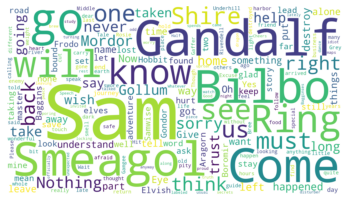

In [90]:
# generate wordcloud
wordcloud_frodo = make_wordcloud(frodo_all)

In [91]:
# count word frequencies
word_frequency_frodo = get_word_frequency(frodo_all, 15)
for key, value in word_frequency_frodo:
    print(f'{key}: {value}')

Sam: 69
Gandalf: 20
Smeagol: 19
Bilbo: 16
will: 16
know: 12
Come: 12
go: 11
Ring: 10
must: 9
us: 9
see: 8
right: 8
back: 8
one: 8


In [92]:
# save wordcloud file
# wordcloud_frodo.to_file("visualizations/wordcloud_frodo.jpg")

In [93]:
# How many times does Frodo say "Sam"?
frodo_says_sam = word_freq(frodo_all, "sam")
frodo_says_sam

73

In [94]:
# How many times does Frodo say "Gandalf"?
frodo_says_sam = word_freq(frodo_all, "gandalf")
frodo_says_sam

21

In [95]:
# PROBLEM: Why does the letter "s" appear as a separate word in the cloud? Does not make sense!
# Test if it has to do with "'s" by replacing all of them with "is" 
# (disclaimer: only for testing since "'s" does not always stand for "is" but can also stand for "has" or genitive s etc.)
frodo_all_without_s = re.sub(r"It\’s", "It is", frodo_all)
frodo_all_without_s = re.sub(r"\'s", " is", frodo_all_without_s)
frodo_all_without_s = re.sub(r"\’s", " is", frodo_all_without_s)
frodo_all_without_s

" You're late. It is wonderful to see you, Gandalf! You know Bilbo. He is got the whole piece in an uproar. Half the Shire is been invited. And the rest of them are turning up anyway. To tell you the truth, Bilbo is been a bit odd lateIy. I mean, more than usual. He is taken to locking himself in his study. He spends hours and hours poring over old maps when he thinks I'm not looking. He is up to something. All right, then. Keep your secrets. But I know you have something to do with it. Before you came along, we Bagginses were very well thought of. Never had any adventures or did anything unexpected. Whatever you did, you've been officially labeled a disturber of the peace. Gandalf? I'm glad you're back. Go on, Sam. Ask Rosie for a dance. Oh, no, you don't. Go on! Bilbo? Bilbo, have you been at the Gaffer is home brew? Bilbo. Bilbo, watch out for the dragon! Speech! Bilbo! Bilbo! He is gone, hasn't he? He talked for so long about leaving  I didn't think he'd really do it. Gandalf? Wher

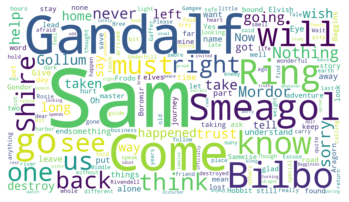

In [96]:
wordcloud_frodo = WordCloud(background_color = 'white', collocations=False, width=1920, height=1080).generate(frodo_all)
plt.imshow(wordcloud_frodo, interpolation="bilinear")
plt.axis("off")
plt.show()

In [97]:
# "'s" still appears as separate word -> WHY?

### Wordcloud - Gandalf

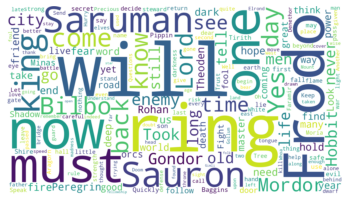

In [98]:
wordcloud_gandalf = make_wordcloud(gandalf_all)

In [99]:
# save wordcloud file
# wordcloud_gandalf.to_file("visualizations/wordcloud_gandalf.jpg")

### Wordcloud - Sam

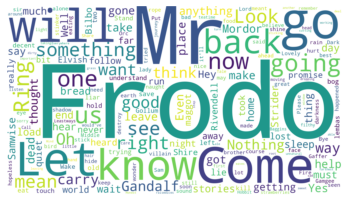

In [100]:
wordcloud_sam = make_wordcloud(sam_all)

In [101]:
# save wordcloud file
# wordcloud_sam.to_file("visualizations/wordcloud_sam.jpg")

### Wordcloud - Merry

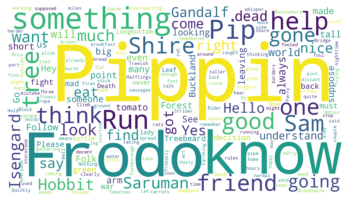

In [102]:
wordcloud_merry = make_wordcloud(merry_all)

In [103]:
# save wordcloud file
# wordcloud_merry.to_file("visualizations/wordcloud_merry.jpg")

### Wordcloud - Pippin

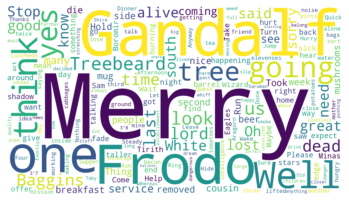

In [104]:
wordcloud_pippin = make_wordcloud(pippin_all)

In [105]:
# save wordcloud file
# wordcloud_pippin.to_file("visualizations/wordcloud_pippin.jpg")

### Wordcloud - Aragorn

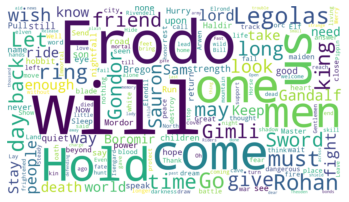

In [106]:
wordcloud_aragorn = make_wordcloud(aragorn_all)

In [107]:
# save wordcloud file
# wordcloud_aragorn.to_file("visualizations/aragorn_gandalf.jpg")

### Wordcloud - Arwen

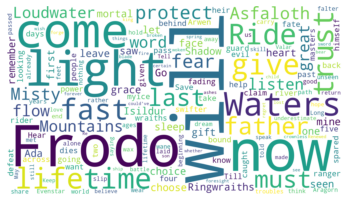

In [108]:
wordcloud_arwen = make_wordcloud(arwen_all)

In [109]:
# save wordcloud file
# wordcloud_arwen.to_file("visualizations/wordcloud_arwen.jpg")

### Wordcloud - Eowyn

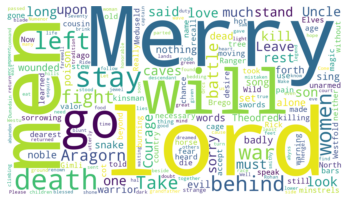

In [110]:
wordcloud_eowyn = make_wordcloud(eowyn_all)

In [111]:
# save wordcloud file
# wordcloud_eowyn.to_file("visualizations/wordcloud_eowyn.jpg")

### Wordcloud - Legolas

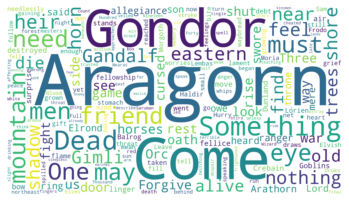

In [112]:
wordcloud_legolas = make_wordcloud(legolas_all)

In [113]:
# save wordcloud file
# wordcloud_legolas.to_file("visualizations/wordcloud_legolas.jpg")

### Wordcloud - Gimli

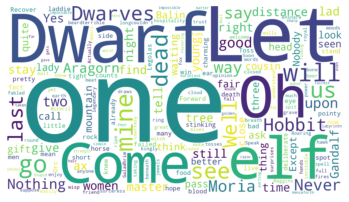

In [114]:
wordcloud_gimli = make_wordcloud(gimli_all)

In [115]:
# save wordcloud file
# wordcloud_gimli.to_file("visualizations/wordcloud_gimli.jpg")

### Wordcloud - Theoden

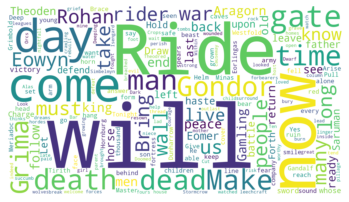

In [116]:
wordcloud_theoden = make_wordcloud(theoden_all)

In [117]:
# save wordcloud file
# wordcloud_theoden.to_file("visualizations/wordcloud_theoden.jpg")

### Wordcloud - Saruman

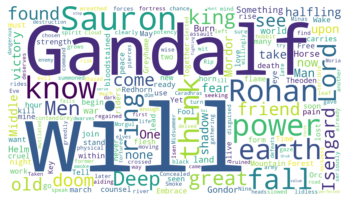

In [118]:
wordcloud_saruman = make_wordcloud(saruman_all)

In [119]:
# save wordcloud file
# wordcloud_saruman.to_file("visualizations/wordcloud_saruman.jpg")

### Wordcloud - Gollum

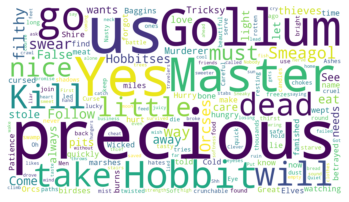

In [120]:
wordcloud_gollum = make_wordcloud(gollum_all)

In [121]:
# save wordcloud file
# wordcloud_gollum.to_file("visualizations/wordcloud_gollum.jpg")

Spannend bei Gollum/Smeagol: Bei allen anderen Figuren sind die Namen anderer Personen unter den häufigsten Wörtern, bei Gollum/Smeagol jedoch sein eigener Name -> zeigt Selbstbezogenheit und Isolation der Figur

### Wordcloud - Smeagol

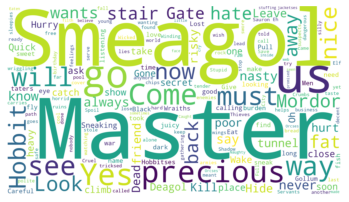

In [122]:
wordcloud_smeagol = make_wordcloud(smeagol_all)

In [123]:
# save wordcloud file
# wordcloud_smeagol.to_file("visualizations/wordcloud_smeagol.jpg")

### Wordcloud - Sauron

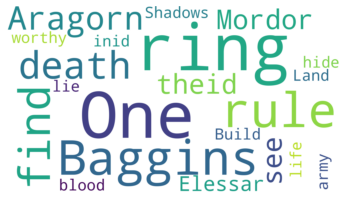

In [124]:
wordcloud_sauron = make_wordcloud(sauron_all)

In [125]:
# save wordcloud file
# wordcloud_sauron.to_file("visualizations/wordcloud_sauron.jpg")

## Word frequency tables

In [126]:
# FRODO
word_frequency_frodo = get_word_frequency(frodo_all, 15)
for key, value in word_frequency_frodo:
    print(f'{key}: {value}')

Sam: 69
Gandalf: 20
Smeagol: 19
Bilbo: 16
will: 16
know: 12
Come: 12
go: 11
Ring: 10
must: 9
us: 9
see: 8
right: 8
back: 8
one: 8


In [127]:
# GANDALF
word_frequency_gandalf = get_word_frequency(gandalf_all, 15)
for key, value in word_frequency_gandalf:
    print(f'{key}: {value}')

will: 54
ring: 35
Frodo: 32
must: 23
now: 22
Saruman: 19
Sauron: 17
one: 16
Yes: 13
know: 13
back: 12
see: 11
come: 11
old: 10
Bilbo: 10


In [128]:
# MERRY
word_frequency_merry = get_word_frequency(merry_all, 15)
for key, value in word_frequency_merry:
    print(f'{key}: {value}')

Pippin: 20
Frodo: 11
know: 9
something: 7
Pip: 7
Run: 6
one: 5
Sam: 5
gone: 5
going: 5
help: 5
good: 4
think: 4
look: 4
Shire: 4


In [129]:
# PIPPIN
word_frequency_pippin = get_word_frequency(pippin_all, 15)
for key, value in word_frequency_pippin:
    print(f'{key}: {value}')

Merry: 32
Gandalf: 12
Frodo: 9
one: 7
think: 7
going: 6
Well: 5
us: 5
Baggins: 4
last: 4
tree: 4
Treebeard: 4
dead: 4
lord: 4
Oh: 3


In [130]:
# ARAGORN
word_frequency_aragorn = get_word_frequency(aragorn_all, 15)
for key, value in word_frequency_aragorn:
    print(f'{key}: {value}')

will: 29
Frodo: 19
us: 13
Legolas: 10
come: 10
must: 9
one: 8
Rohan: 8
day: 8
may: 7
back: 7
Gimli: 7
time: 7
wish: 6
ring: 6


In [131]:
# ARWEN
word_frequency_arwen = get_word_frequency(arwen_all, 15)
for key, value in word_frequency_arwen:
    print(f'{key}: {value}')

will: 10
Frodo: 6
now: 6
come: 4
light: 4
Ride: 3
fast: 3
give: 3
time: 3
life: 3
trust: 3
last: 2
must: 2
father: 2
protect: 2


In [132]:
# EOWYN
word_frequency_eowyn = get_word_frequency(eowyn_all, 15)
for key, value in word_frequency_eowyn:
    print(f'{key}: {value}')

lord: 6
Merry: 6
men: 5
go: 3
death: 3
stay: 3
behind: 3
war: 3
fight: 3
Take: 3
Aragorn: 3
will: 3
battle: 3
left: 3
son: 2


In [133]:
# LEGOLAS
word_frequency_legolas = get_word_frequency(legolas_all, 15)
for key, value in word_frequency_legolas:
    print(f'{key}: {value}')

Aragorn: 8
Gondor: 3
must: 3
Come: 3
Dead: 3
heir: 2
nothing: 2
Gandalf: 2
shadow: 2
near: 2
One: 2
eastern: 2
shore: 2
Something: 2
feel: 2


In [134]:
# GIMLI
word_frequency_gimli = get_word_frequency(gimli_all, 15)
for key, value in word_frequency_gimli:
    print(f'{key}: {value}')

one: 11
Let: 7
Dwarf: 7
Oh: 7
will: 6
Come: 6
see: 5
us: 5
go: 5
way: 4
Moria: 4
mine: 4
upon: 4
Well: 4
Dwarves: 4


In [135]:
# THEODEN
word_frequency_theoden = get_word_frequency(theoden_all, 15)
for key, value in word_frequency_theoden:
    print(f'{key}: {value}')

will: 17
now: 7
come: 7
dead: 6
gate: 6
Gondor: 6
Ride: 6
Grima: 5
Eowyn: 5
days: 5
us: 5
people: 5
Rohan: 5
time: 5
man: 5


In [136]:
# SARUMAN
word_frequency_saruman = get_word_frequency(saruman_all, 15)
for key, value in word_frequency_saruman:
    print(f'{key}: {value}')

will: 21
Gandalf: 10
Sauron: 6
know: 6
Rohan: 6
power: 5
fall: 5
think: 4
Isengard: 3
come: 3
friend: 3
ring: 3
found: 3
none: 3
Lord: 3


In [137]:
# GOLLUM
word_frequency_gollum = get_word_frequency(gollum_all, 15)
for key, value in word_frequency_gollum:
    print(f'{key}: {value}')

us: 21
precious: 18
Gollum: 13
Yes: 12
go: 7
Master: 7
will: 6
little: 5
Kill: 5
Precious: 5
dead: 5
Smeagol: 5
nice: 4
master: 4
Orcses: 4


In [138]:
# SMEAGOL
word_frequency_smeagol = get_word_frequency(smeagol_all, 15)
for key, value in word_frequency_smeagol:
    print(f'{key}: {value}')

Smeagol: 23
us: 16
precious: 15
Master: 14
go: 12
master: 11
Yes: 11
will: 11
way: 10
must: 10
Come: 9
see: 8
now: 8
nice: 7
Mordor: 6


In [139]:
# SAURON
word_frequency_sauron = get_word_frequency(sauron_all, 15)
for key, value in word_frequency_sauron:
    print(f'{key}: {value}')

One: 9
ring: 9
Baggins: 5
rule: 5
find: 4
death: 3
Aragorn: 3
see: 2
Mordor: 2
Elessar: 2
hide: 1
life: 1
theid: 1
Build: 1
army: 1


## First Sentiment Analysis test using TextBlob

Info:
* Video: [Sentiment Analysis using Textblob](https://www.youtube.com/watch?v=6bg-TNoT5_Y)
* Text Tutorial: [Sentiment Analysis in Python with Textblob](https://stackabuse.com/sentiment-analysis-in-python-with-textblob/)
* Doku: [spacytextblob](https://spacy.io/universe/project/spacy-textblob)

Prerequisites:
spacy, language model "en_core_web_sm", textblob, textblob corpus, spacytextblob (spacy pipeline component) installed

textblob: `pip3 install -U textblob`
textblob corpus: `python -m textblob.download_corpora`
spacytextblob: `pip install spacytextblob`

In [140]:
# load spacy
nlp = spacy.load("en_core_web_sm")

In [141]:
# show current spacy pipeline
nlp.components

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x16aea6680a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x16aea668d60>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x16ae3f68e40>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x16aea6b4ca0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x16aeb34e600>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x16ae866e6c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x16ae3f6a960>)]

In [142]:
# add Textblob to pipeline
nlp.add_pipe("spacytextblob")

In [143]:
# check if added to pipe
nlp.components

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x16aea6680a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x16aea668d60>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x16ae3f68e40>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x16aea6b4ca0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x16aeb34e600>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x16ae866e6c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x16ae3f6a960>),
 ('spacytextblob',
  <spacytextblob.spacytextblob.SpacyTextBlob at 0x16ae86383a0>)]

#### Sentiment Analysis with test text

In [144]:
# test text
text = "I love the lord of the rings. But I hate Sauron."

# doc of test text
doc = nlp(text)

In [145]:
# Sentiment Analysis: check polarity
# from -1.0 to 1.0
doc._.polarity

-0.15000000000000002

In [146]:
# Sentiment Analysis: check objectivity/subjectivity
doc._.subjectivity

0.75

In [147]:
# complete Sentiment Analysis
doc._.assessments
# Output: [(['love'], 0.5, 0.6, None)]
# ausschlaggebendes Wort, polarity, subjectivity

[(['love'], 0.5, 0.6, None), (['hate'], -0.8, 0.9, None)]

#### Sentiment Analysis zu Frodos Text 

In [148]:
# make doc of frodos dialog text
doc_frodo = nlp(frodo)

# frodo assessment
frodo_sa = doc_frodo._.assessments
frodo_sa

NameError: name 'frodo' is not defined

In [ ]:
# Wie viele Sätze
sentences = frodo.split(".")
len(sentences)

In [ ]:
# Wie viele Sätze nach NLP
len(frodo_sa)

In [ ]:
# Warum verschiedene Ergebnisse bei Anzahl der Sätze???